# Chap03 - 분류 Classification

## 3.1 MNIST

이번 장에서는 필기체 숫자로 이루어진 'MNIST 데이터베이스'를 이용해 필기체 숫자 분류를 해보자. MNIST는 미국 인구조사국으 지기원들이 쓴 숫자와 고등학생들이 쓴 숫자로 만든 미국 국립표준기술연구소(NIST)의 데이터베이스를 다시 섞어 만든 필기체 숫자 이미지 데이터베이스이다. 

MNIST 데이터는 딥러닝 예제에서 빠지지 않고 등장하는 데이터라고 할 수 있다. 

![](./images/mnist.png)

### SetUp

In [1]:
# 공통
import os
import numpy as np

np.random.seed(42)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
sn.set()

# 한글출력
matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

### MNIST

In [2]:
from tensorflow.keras.datasets import mnist

(train_x, train_y), (test_x, test_y) = mnist.load_data()

11493376/11490434 [==============================] - 3s 0us/step


In [3]:
X = np.vstack((train_x, test_x))
X = X.reshape([-1, 28*28])

y = np.append(train_y, test_y)

print('X.shape :', X.shape)
print('y.shape :', y.shape)

X.shape : (70000, 784)
y.shape : (70000,)


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


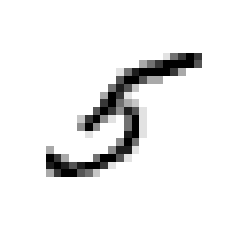

In [4]:
some_digit = X[35]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")
plt.show()

MNIST 데이터셋을 Train Set과 Test Set을 나누어 보자.

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

print('X_train.shape :', X_train.shape)
print('X_test.shape :', X_test.shape)
print('y_train.shape :', y_train.shape)
print('y_test.shape :', y_test.shape)

X_train.shape : (60000, 784)
X_test.shape : (10000, 784)
y_train.shape : (60000,)
y_test.shape : (10000,)


## 3.2 이진 분류기 훈련

문제를 단순화하기 위해 하나의 숫자 5만 식별하는 분류기를 구현해보자. 숫자가 5인지 아닌지를 분류하는 **이진 분류기**(binary classifier)를 분류 해본다.

In [6]:
y_train_5 = (y_train == 5)  # 5는 True, 다른 숫자는 False
y_test_5 = (y_test == 5)

In [7]:
np.where(y_train == 5)

(array([    8,    11,    25, ..., 59928, 59942, 59965], dtype=int64),)

이제 Scikit-Learn의 `SGDClassifier`를 이용해 분류기를 구현해보도록 하자. `SGDClassifier`는 **확률적 경사 하강법**(Stochastic Gradient Descent)을 이용한 Linear classifiers (SVM, logistic regression, a.o.)이다. 디폴트 값으로는 `loss='hinge'`이며, linear SVM을 이용해 분류기를 학습한다.

`SGDClassifier`는 매우 큰 데이터셋을 효율적으로 처리하는 장점이 있다. 

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X_train, y_train_5)

C:\Users\jungh\.conda\envs\test3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


SGDClassifier(max_iter=5, random_state=42)

In [9]:
# some_digit = X[35]
sgd_clf.predict([some_digit])

array([False])

## 3.3 성능 측정

### 3.3.1 교차 검증을 사용한 정확도 측정

In [10]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

C:\Users\jungh\.conda\envs\test3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\jungh\.conda\envs\test3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\jungh\.conda\envs\test3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.964 , 0.9579, 0.9571])

아래의 예제코드는 위의 `cross_val_score`과 같은 기능을 하는 교차 검증 기능을 `StratifiedKFold`를 이용해 직접 구현한 코드이다. `StratifiedKFold`는 클래스별 비율이 유지되도록 폴드(Fold)를 만들기 위해 계층적 샘플링을 수행한다. 

출력 결과는 위의 결과와 동일한 결과가 출력된다.

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)  # sgd_clf 복제
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

C:\Users\jungh\.conda\envs\test3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
C:\Users\jungh\.conda\envs\test3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


0.964


C:\Users\jungh\.conda\envs\test3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


0.9579
0.9571


C:\Users\jungh\.conda\envs\test3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


모든 이미지를 `5가 아님`으로 분류하는 더미 분류기를 만들어 보자.

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [13]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90745, 0.9125 ])

위의 결과에서 알 수 있듯이, 모든 숫자를 `5가 아님`으로 분류해도 정확도가 90% 이상이다. 그 이유는 전체 데이터셋 중 10% 정도만이 숫자 5이기 때문이다.

따라서, 정확도(accuracy)를 성능 측정 지표로 사용하는 것은 **불균형한 데이터셋**을 다룰 때 유용하지 않다.

### 3.3.2 오차 행렬 (Confusion Matrix)

- **TP** : True-Positive, 1이라고 예측했는데, 실제로도 1인 경우 → **정답**
- **TN** : True-Negative, 0이라고 예측했는데, 실제로도 0일 경우 → **정답**
- **FP** : False-Positive, 1이라고 예측했는데, 실제로는 0인 경우
- **FN** : False-Negative, 0이라고 예측했는데, 실제로는 1인 경우

![](./images/confusion_matrix.png)

`cross_val_predict()`는 K-Fold CV를 수행하면서 score값이 아닌 예측 값을 반환한다.

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

C:\Users\jungh\.conda\envs\test3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\jungh\.conda\envs\test3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\jungh\.conda\envs\test3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([False, False, False, ..., False, False, False])

`confusion_matrix()`에서 행은 **실제 클래스**를 나타내고 열은 **예측한 클래스**를 나타낸다.

In [15]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred )

array([[54058,   521],
       [ 1899,  3522]], dtype=int64)

In [16]:
confusion_matrix(y_train_5, y_train_5)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

### 3.3.3 정밀도와 재현율 

#### Precision (정밀도)

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

In [17]:
precision = 4432 / (4432 + 1607)
precision

0.7338963404537175

In [18]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8711352955725946

#### Recall (재현율)

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

In [19]:
recall = 4432 / (4432 + 989)
recall

0.8175613355469471

In [21]:
recall_score(y_train_5, y_train_pred)

0.6496956281128943

#### $\text{F}_{1}$ Score

$$
\text{F}_{1} = \frac{2}{\frac{1}{\text{Precision}} + \frac{1}{\text{Recall}}} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} = \frac{TP}{TP + \frac{FN + FP}{2}}
$$

In [22]:
f1_score_ = 4432 / (4432 + (989 + 1607)/2)
f1_score_

0.7734729493891798

In [23]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7442941673710904

### 3.3.4 정밀도/재현율 Trade-Off

![](./images/tradeoff.png)

In [24]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-9737.07850237])

In [25]:
threshold = 0
y_some_digit_pred = (y_scores < threshold)
y_some_digit_pred

array([ True])

In [26]:
threshold = -200000
y_some_digit_pred = (y_scores < threshold)
y_some_digit_pred

array([False])

In [27]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

C:\Users\jungh\.conda\envs\test3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\jungh\.conda\envs\test3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\jungh\.conda\envs\test3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [28]:
y_scores.shape

(60000,)

In [29]:
y_scores

array([-545086.1906455 , -200238.20632717, -366873.76172794, ...,
       -626454.84454281, -716313.74931348, -581950.04601147])

In [30]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
C:\Users\jungh\.conda\envs\test3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51076 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jungh\.conda\envs\test3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 44228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jungh\.conda\envs\test3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 44050 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jungh\.conda\envs\test3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jungh\.conda\envs\test3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:

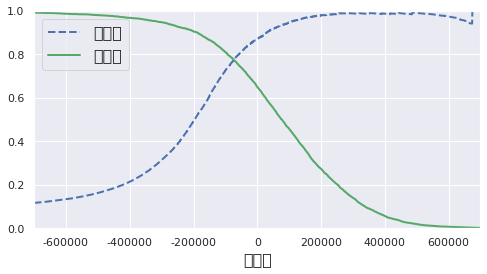

In [31]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="정밀도", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="재현율", linewidth=2)
    plt.xlabel("임계값", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

C:\Users\jungh\.conda\envs\test3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51116 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jungh\.conda\envs\test3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54788 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jungh\.conda\envs\test3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50984 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jungh\.conda\envs\test3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jungh\.conda\envs\test3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jungh\.conda\envs\test3\lib\site-packages\matplotlib\backends\backend_agg.py

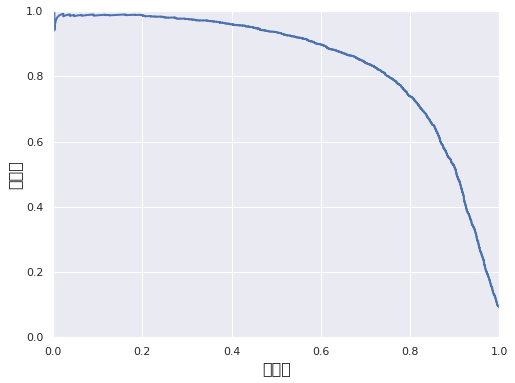

In [32]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("재현율", fontsize=16)
    plt.ylabel("정밀도", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

Precision/Recall Trade-off는 위의 그래프에서 하강점 직전, 즉 0.6(60%) 지점을 선택하는 것이 좋다. 물론 이러한 선택은 프로젝트에 따라 다르다.

만약, 정밀도(Precision)을 90% 달성하는 것이 목표라고 하면, 임계값(threshold)을 조정하여 구할 수 있다.

In [33]:
y_train_pred_90 = (y_scores > 110000)
y_train_pred_90

array([False, False, False, ..., False, False, False])

In [34]:
precision_score(y_train_5, y_train_pred_90)

0.9520383693045563

In [35]:
recall_score(y_train_5, y_train_pred_90)

0.4394023242944106

하지만, 위의 결과에서도 볼 수 있듯이, 정밀도가 올라가면 재현율은 떨어지기 마련이다. 따라서, 정밀도가 높지만 재현율이 낮은 분류기는 유용하지 않다.

> 누군가가 '99% 정밀도를 달성하자'라고 하면 반드시 '재현율 얼마에서?'라는 질문을 던져야 한다!

### 3.3.5 ROC 곡선

ROC(Receiver Operating Characteristic, 수신자 조작 특성)곡선 또한 이진 분류에서 주로 사용한다. ROC 곡선은 **False-Positive Rate(FPR)**에 대한 **True-Positive Rate(TPR = Recall)**의 곡선이다. 

FPR은 1에서 TNR(True-Negative Rate)를 뺀 값과 같다. TNR은  **특이도**(Specificity)라고도 한다.

$$
FPR = \frac{FP}{FP + TN} = \frac{FP + TN - TN}{FP + TN} = 1 - \frac{TN}{FP + TN} = 1 - TNR
$$

따라서, ROC 곡선은 **민감도(재현율, Recall)**에 대한 **1 - 특이도** 그래프이다.

In [38]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

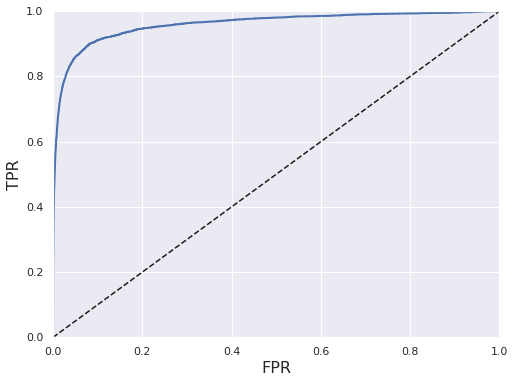

In [39]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('FPR', fontsize=16)
    plt.ylabel('TPR', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

위의 ROC 곡선에서도 trade-off가 있다. 재현율(TPR, Recall)이 높을수록 FPR이 증가한다. 점선은 랜덤한 분류기의 ROC곡선을 의미하며, 성능이 좋은 분류기는 점선에서 부터 최대한 멀리 떨어져야한다(왼쪽 위 모서리).

**AUC**(Area Under the Curve)을 측정하면 분류기들을 성능을 비교할 수 있다. AUC는 1에 가까울 수록 좋은 분류기이다.

In [40]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9598058535696421

아래의 코드는 SGDClassifier와 RandomForestClassifier의 ROC 곡선과 AUC를 비교하는 코드이다.

In [41]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [42]:
y_scores_forest = y_probas_forest[:, 1] # 점수는 양성 클래스의 확률
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

C:\Users\jungh\.conda\envs\test3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 47004 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jungh\.conda\envs\test3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 45924 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jungh\.conda\envs\test3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54252 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jungh\.conda\envs\test3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 47112 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jungh\.conda\envs\test3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\jungh\.conda\envs\test3\lib\site-packages\matplotlib\backends\backend_agg.py

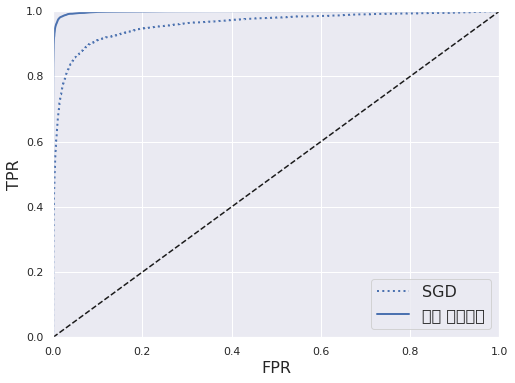

In [43]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "랜덤 포레스트")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [44]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983631764491033

In [45]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9890893831305078

In [46]:
recall_score(y_train_5, y_train_pred_forest)

0.8695812580704667

## 3.4 다중 분류

다중 분류(multiclass/multinomial classification)는 말그대로 둘 이상의 클래스로 분류하는 것을 말한다.

RandomForest나 Naive Bayes같은 알고리즘은 알고리즘에서 직접 다중 분류가 가능하지만, SVM이나 Logistic Regression같은 알고리즘은 이진 분류(binary classification)만 가능하다. 

하지만, 이러한 이진 분류 알고리즘을 여러 번 사용해 다중 클래스를 분류할 수 있는 기법(트릭)이 있다. 

#### OvA(One versus All, One versus the rest, OvR)

**OvA(일대다)**방법은 예를 들어, MNIST 데이터에서 특정 숫자 하나만 분류하는 (1인지 아닌지?, 2인지 아닌지?) 이진 분류기를 10개 만들어 그 중 가장 높은 확률(점수)값을 가지는 클래스로 분류해주는 방법이다.

#### OvO(One versus One)

**OvO(일대일)** 방법은 0과 1, 0과 2, 1과 2 구별 등과 같이 각 클래스의 조합마다 이진 분류기를 만들어 학습시키는 방법이다. 이 방법은 클래스가 $N$개인 경우 $\frac{N \times \left( N-1 \right)}{2}$ 개가 필요하다.

$$
\binom{N}{2} = \frac{N!}{2! \left(N-2\right)!} = \frac{N \times \left( N-1 \right)}{2}
$$ 

MNIST의 경우에는 45개의 분류기를 만들어 가장 많이 Positive로 분류된 클래스를 선택한다. 

SVM같은 알고리즘은 Train Set의 크기에 민감하기 때문에 작은 Train Set에서 여러개의 분류기를 학습시키는 것이 빠르기 때문에 OvO를 사용하지만, 대부분의 이진 분류 알고리즘은 OvA를 사용한다.

Scikit-Learn에서는 이진 분류 알고리즘을 이용해 다중 분류를 수행할 경우 자동으로 OvA(또는 SVM일 경우 OvO)를 적용해 학습한다.

In [47]:
sgd_clf.fit(X_train, y_train)

C:\Users\jungh\.conda\envs\test3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


SGDClassifier(max_iter=5, random_state=42)

In [48]:
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

In [49]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-316862.83301713, -126087.57115116, -323328.01533723,
        -172686.08830523, -151770.51458938,  125765.87830601,
        -532184.20022905, -505026.02263703,  -68942.92775798,
        -426178.30837231]])

In [50]:
np.argmax(some_digit_scores)

5

Scikit-Learn에서 OvO나 OvA를 사용하도록 `OneVsOneClassifier`나 `OneVsRestClassifier`를 이용해 지정할 수 있다. 

In [51]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo_clf.fit(X_train, y_train)

C:\Users\jungh\.conda\envs\test3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\jungh\.conda\envs\test3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\jungh\.conda\envs\test3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\jungh\.conda\envs\test3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users

C:\Users\jungh\.conda\envs\test3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\jungh\.conda\envs\test3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\jungh\.conda\envs\test3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\jungh\.conda\envs\test3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users

OneVsOneClassifier(estimator=SGDClassifier(max_iter=5, random_state=42))

In [52]:
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [53]:
len(ovo_clf.estimators_)

45

RandomForest 같은 알고리즘은 알고리즘 자체에서 다중 클래스로 분류할 수 있기 때문에 OvA, OvO 같은 방법이 필요하지 않다. 

In [54]:
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [55]:
forest_clf.predict([some_digit])

array([5], dtype=uint8)

In [56]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.01, 0.  , 0.03, 0.  , 0.95, 0.  , 0.  , 0.01, 0.  ]])

In [57]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

C:\Users\jungh\.conda\envs\test3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\jungh\.conda\envs\test3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\jungh\.conda\envs\test3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.83935, 0.85125, 0.8676 ])

#### StandardScaler를 이용해 데이터 스케일 조정하기

In [58]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

C:\Users\jungh\.conda\envs\test3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\jungh\.conda\envs\test3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\jungh\.conda\envs\test3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.91155, 0.91005, 0.9095 ])

## 3.5 에러 분석

In [59]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

C:\Users\jungh\.conda\envs\test3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\jungh\.conda\envs\test3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\jungh\.conda\envs\test3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5722,    2,   28,    9,    8,   49,   51,   11,   41,    2],
       [   2, 6494,   47,   23,    6,   42,    5,   10,  100,   13],
       [  51,   37, 5360,   88,   82,   23,   96,   56,  149,   16],
       [  51,   37,  149, 5318,    2,  248,   37,   57,  134,   98],
       [  19,   25,   39,    8, 5378,    7,   54,   29,   77,  206],
       [  73,   42,   35,  170,   73, 4622,  105,   30,  177,   94],
       [  31,   24,   43,    2,   43,   88, 5635,    4,   47,    1],
       [  20,   20,   65,   27,   58,   11,    6, 5806,   12,  240],
       [  53,  147,   78,  164,   11,  163,   56,   24, 5017,  138],
       [  42,   27,   25,   87,  175,   34,    3,  201,   85, 5270]],
      dtype=int64)

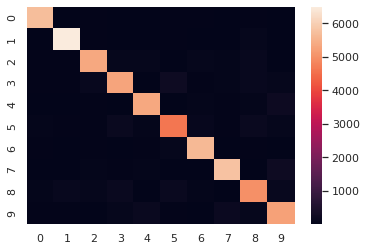

In [60]:
sn.heatmap(conf_mx);

In [61]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

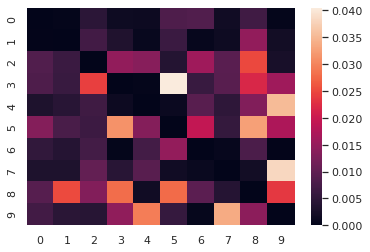

In [62]:
np.fill_diagonal(norm_conf_mx, 0)
sn.heatmap(norm_conf_mx);

In [63]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

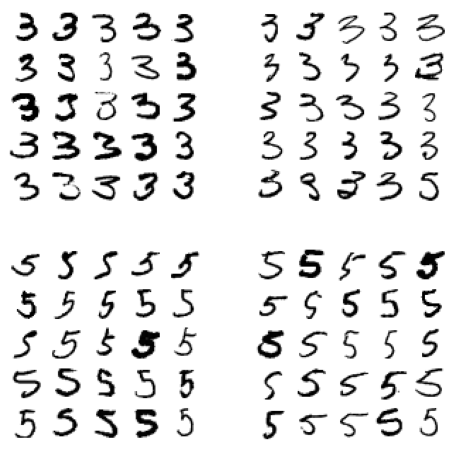

In [64]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## 3.6 다중 레이블 분류

위에서 살펴본 내용은 데이터가 하나의 클래스에만 분류되는 경우만 살펴보았다. 하지만, 데이터에 따라 여러개의 클래스에 분류해야하는 경우가 있다. 이러한 경우를 **다중 레이블 분류**(multilabel classification)이라고 한다.

아래의 예제는 `kNN`알고리즘을 이용한 `KNeighborClassifier` 분류기를 사용해 첫번째 클래스는 7보다 크거나 같은지(`>=7`), 두 번째 클래스는 홀수(odd)인지를 분류하는 다중 레이블 분류 예제이다. 

In [65]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [66]:
knn_clf.predict([some_digit])  # == 5

array([[False,  True]])

In [68]:
%%time
# y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
print(f1_score(y_multilabel, y_train_knn_pred, average="macro"))

NameError: name 'y_train_knn_pred' is not defined

## 3.7 다중 출력 분류

In [69]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [70]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

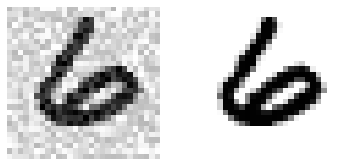

In [71]:
some_index = 5501
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

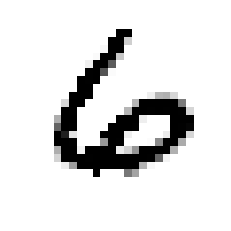

In [72]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

===================================================================================

In [73]:
# 3.1

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

## 4.1
확률적 경사 하강법, 미니배치 경사하강법

## 4.11
두 개의 로지스틱 회귀 분류기